In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Data Preparation
Database consists of 100,000 enteries for yield production for a week(1 jan to 7 Jan) from different plants
*I have manually changed the format in csv file to yy-mm-dd to match the format with Pandas Datatime. Also the commas(,) have been relpaced with (.)*

In [41]:
df= pd.read_csv('plantsYieldGmi.csv',sep=';', squeeze=True, parse_dates=True, header=0, index_col= 'date') #usecols=[1,2])
#df = df.apply(lambda x: x.str.replace(',','.'))
#df= df.drop(['id', 'unit'], axis=1)

In [42]:
print(df['yield'])

date
2019-01-01    0.00
2019-01-01    0.00
2019-01-01    0.00
2019-01-01    0.00
2019-01-01    0.00
              ... 
2019-01-07    0.96
2019-01-07    0.96
2019-01-07    0.96
2019-01-07    0.96
2019-01-07    0.96
Name: yield, Length: 100000, dtype: float64


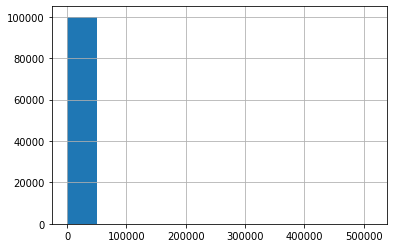

In [43]:
df['yield'].hist()
plt.show()

In [45]:
df.tail()

,id,yield,unit
date,,,
2019-01-07,215,0.96,kWh
2019-01-07,604,0.96,kWh
2019-01-07,1780,0.96,kWh
2019-01-07,2801,0.96,kWh
2019-01-07,3050,0.96,kWh


In [46]:
#converting index of datetimes to a DatetimeIndex
df.index = pd.to_datetime(df.index, format='%Y/%m/%d')
print(df.index.dtype)
print(df.index.freq)

datetime64[ns]
None


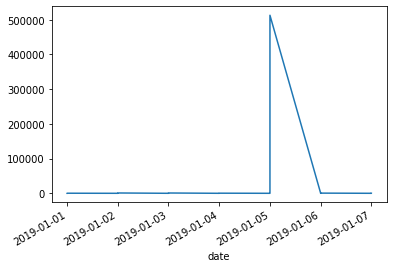

In [47]:
# As per this plot, the maximum yield produced by plants is on 5th and 6th january,2019
df['yield'].plot()

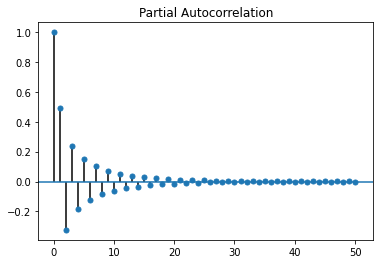

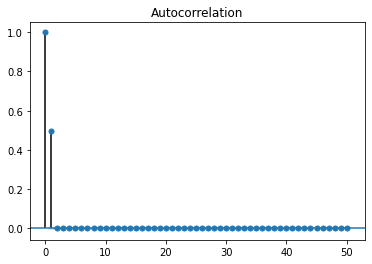

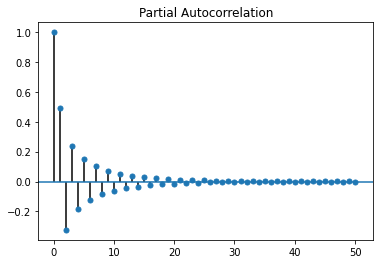

In [8]:
#plotting autocorrelation and partial correlation
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(df)
plot_pacf(df)

Data enteries seems to be highly correlated and no trend or seasonality observed, as the data is only for single month and only 1 year, hence showing sharp increase only on 5th and 6th day of the month January

#Normalization of series values
In the database,Under row 81154 and 81155, for Plant Id 21432 and 2190, the yield is 444730 and 513040 kWh which is too high if we look over the rest data. So we are normalizing the data to avoid overfitting

#y = (x - min) / (max - min)


In [38]:
# from sklearn.preprocessing import MinMaxScaler
# values = df.values
# print(values)
# values = values.reshape((len(values), 1))
# # train the normalization
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaler = scaler.fit(values)
# print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))
# # normalize the dataset and print the first 5 rows
# df_normalized = scaler.transform(values)
# for i in range(10):
# 	print(df_normalized[i])
# # inverse transform and print the first 5 rows
# inversed = scaler.inverse_transform(df_normalized)
# for i in range(10):
# 	print(inversed[i])
 

[0.   0.   0.   ... 0.96 0.96 0.96]
Min: 0.000000, Max: 513040.000000
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]


# Standardization of data
Another data preprocessing approach could be standardization which used mean and standard deviation

#y = (x - mean) / standard_deviation


In [48]:
# Standardize the data
from pandas import read_csv
from sklearn.preprocessing import StandardScaler
from math import sqrt
# load the dataset and print the first 5 rows
values = df['yield'].values
print(values)
values = values.reshape((len(values), 1))
# train the standardization
scaler = StandardScaler()
scaler = scaler.fit(values)
print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, sqrt(scaler.var_)))
# standardization the dataset and print the first 5 rows
df_norm = scaler.transform(values)
for i in range(10):
	print(df_norm[i])
# # inverse transform and print the first 5 rows
# inversed = scaler.inverse_transform(df_normalized)
# for i in range(10):
# 	print(inversed[i])

[0.   0.   0.   ... 0.96 0.96 0.96]
Mean: 15.450305, StandardDeviation: 2147.068429
[-0.007196]
[-0.007196]
[-0.007196]
[-0.007196]
[-0.007196]
[-0.007196]
[-0.007196]
[-0.007196]
[-0.007196]
[-0.007196]


#Model Building
Using Auto ARIMA 

In [49]:
import warnings
warnings.filterwarnings("ignore")

In [50]:
from statsmodels.tsa.arima_model import ARMA,ARIMA, ARMAResults, ARIMAResults

In [56]:
pip install pmdarima

     |████████████████████████████████| 1.5MB 5.8MB/s 
     |████████████████████████████████| 9.5MB 14.8MB/s 
     |████████████████████████████████| 2.1MB 29.1MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


In [51]:
from pmdarima import auto_arima # for determining ARIMA orders

In [52]:
auto_arima(df['yield'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:               100000
Model:               SARIMAX(0, 0, 1)   Log Likelihood             -881059.886
Date:                Thu, 03 Dec 2020   AIC                        1762125.772
Time:                        15:24:30   BIC                        1762154.311
Sample:                             0   HQIC                       1762134.433
                             - 100000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      8.9996     19.751      0.456      0.649     -29.712      47.711
ma.L1          0.8667   3.84e-05   2.26e+04      0.000       0.867       0.867
sigma2      2.632e+06    142.552   1.85e+04      0.000    2.63e+06    2.63e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):    13681690709244.91
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):           65565.88   Skew:                           208.82
Prob(H) (two-sided):                  0.00   Kurtosis:                     57304.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SARIMAX MODEL

In [57]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(df['yield'].values,order=(0,0,1))
model_fit= model.fit()
rmse = sqrt(mean_squared_error(df['yield'].values,model_fit.fittedvalues)) 
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1622.404


In [58]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:               100000
Model:               SARIMAX(0, 0, 1)   Log Likelihood             -881060.960
Date:                Thu, 03 Dec 2020   AIC                        1762125.921
Time:                        15:40:10   BIC                        1762144.947
Sample:                             0   HQIC                       1762131.695
                             - 100000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.8667    3.8e-05   2.28e+04      0.000       0.867       0.867
sigma2      2.632e+06     69.793   3.77e+04      0.000    2.63e+06    2.63e+06
Ljung-Box (L1) (Q):                   0.00   Jarque-

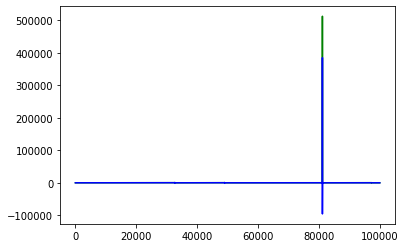

In [61]:
# plot results
plt.plot(df['yield'].values, color='green')
plt.plot(model_fit.fittedvalues, color='blue')
plt.show()